In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [110]:
X_roll, y_roll = datasets.make_swiss_roll(n_samples=1000, noise=.2, random_state=42)

X_roll.shape, y_roll.shape

((1000, 3), (1000,))

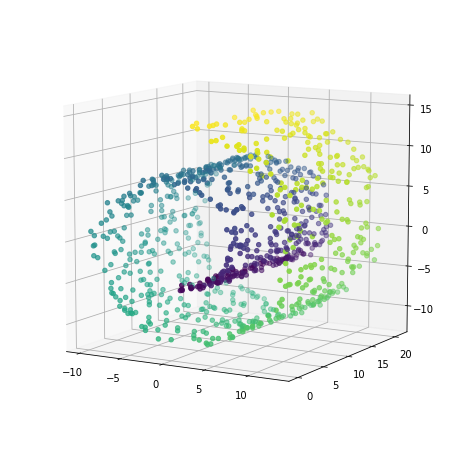

In [111]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(X_roll[:, 0], X_roll[:, 1], X_roll[:, 2], c=y_roll)
ax.view_init(elev=10)

In [15]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

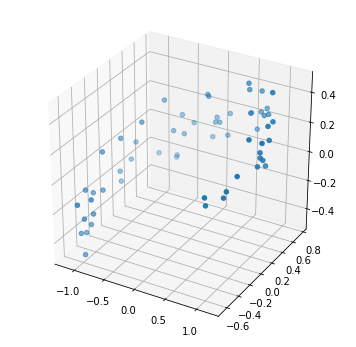

In [16]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o')

In [17]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

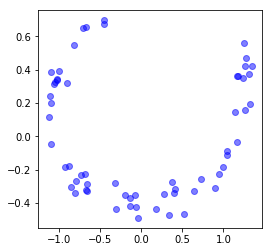

In [18]:
plt.figure(figsize=(4, 4))
plt.plot(X_2d[:, 0], X_2d[:, 1], 'bo', alpha=.5)

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [20]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

#### PCA for Compression

In [55]:
from keras.datasets.mnist import load_data
from sklearn.decomposition import PCA, IncrementalPCA

In [190]:
(X_mnist, y_mnist), (_, _) = load_data()

size = 28

X_mnist = X_mnist.reshape((-1, size*size)) / 255.
X_mnist.shape

(60000, 784)

In [71]:
n_rows, n_cols = 5, 5
rand_idx = np.random.permutation(len(X_mnist))[:n_rows*n_cols]

In [72]:
def display_digits(n_rows, n_cols, rand_idx, data, size=28):
    digits = np.empty(shape=(n_rows*size, n_cols*size))
    for r in range(n_rows):
        for c in range(n_cols):
            idx = r*n_cols + c
            digits[r*size:(r+1)*size, c*size:(c+1)*size] = data[idx].reshape((size,size))
    plt.imshow(digits)

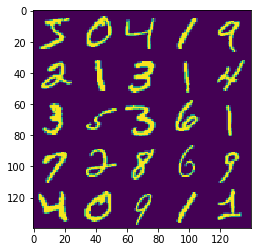

In [73]:
display_digits(n_rows, n_cols, rand_idx, X_mnist)

In [74]:
pca = PCA(n_components=.95)
pca.fit(X_mnist)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [75]:
X_mnist_reduced = pca.transform(X_mnist)
X_mnist_reduced.shape

(60000, 154)

In [76]:
X_mnist_recovered = pca.inverse_transform(X_mnist_reduced)
X_mnist_recovered.shape

(60000, 784)

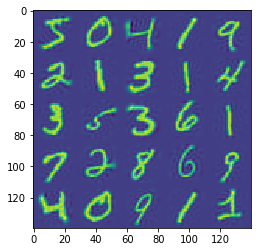

In [77]:
display_digits(n_rows, n_cols, rand_idx, X_mnist_recovered)

In [78]:
pca.components_.shape

(154, 784)

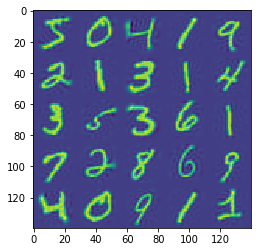

In [79]:
display_digits(n_rows, n_cols, rand_idx, np.dot(X_mnist_reduced, pca.components_)+pca.mean_)

#### Incremental PCA

In [84]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154, batch_size=500)

In [85]:
inc_pca.fit(X_mnist)

IncrementalPCA(batch_size=500, copy=True, n_components=154, whiten=False)

In [86]:
X_mnist_reduced_inc = inc_pca.transform(X_mnist)
X_mnist_reduced_inc.shape

(60000, 154)

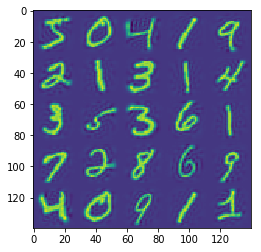

In [88]:
display_digits(n_rows, n_cols, rand_idx, inc_pca.inverse_transform(X_mnist_reduced_inc))

In [90]:
# using np.memmap

m, n = X_mnist.shape
filename = 'mnist.data'

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_mnist

In [91]:
del X_mm

In [97]:
X_mm = np.memmap(filename, dtype='float32', mode='r', shape=(m, n))

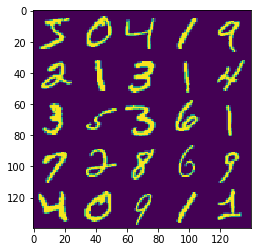

In [98]:
display_digits(n_rows, n_cols, rand_idx, X_mm)

In [99]:
del X_mm

#### Randomized PCA

In [100]:
from sklearn.decomposition import RandomizedPCA

In [104]:
rand_pca = PCA(n_components=154, svd_solver='randomized')

In [105]:
X_reduced_rand = rand_pca.fit_transform(X_mnist)

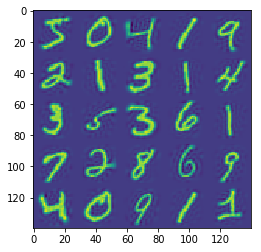

In [106]:
display_digits(n_rows, n_cols, rand_idx, rand_pca.inverse_transform(X_reduced_rand))

In [108]:
X_reduced_rand[0, :10]

array([ 0.48601015, -1.22617358, -0.09613354, -2.17944297, -0.10704576,
       -0.9116717 ,  0.91763033,  0.62666467, -1.42554912,  0.77814934])

In [109]:
X_mnist_reduced[0, :10]

array([ 0.48601015, -1.22617358, -0.09613354, -2.17944297, -0.10704576,
       -0.9116717 ,  0.91763033,  0.62666468, -1.4255491 ,  0.77814932])

#### Kernel PCA

In [112]:
from sklearn.decomposition import KernelPCA

In [116]:
X_roll, y_roll = datasets.make_swiss_roll(n_samples=1000, noise=.2, random_state=42)

In [140]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', 
                    gamma=.04, 
                    fit_inverse_transform=True)
lin_pca = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
sigmoid_pca = KernelPCA(n_components=2, kernel='sigmoid', coef0=1, 
                        gamma=.001, 
                        fit_inverse_transform=True)

In [141]:
X_roll_rbf = rbf_pca.fit_transform(X_roll)
X_roll_lin = lin_pca.fit_transform(X_roll)
X_roll_smd = sigmoid_pca.fit_transform(X_roll)

Text(0.5,1,'Sigmoid kernel, $\\gamma=10^{-3}$, r=1')

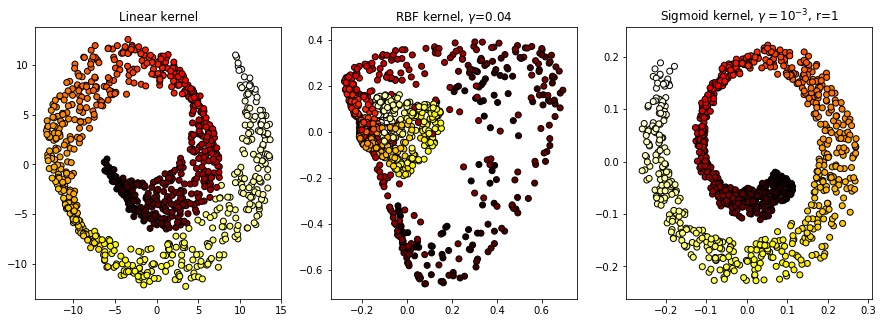

In [142]:
plt.figure(figsize=(15, 5))


plt.subplot(131)
plt.scatter(X_roll_lin[:, 0], X_roll_lin[:, 1], c=y_roll, edgecolors='k', cmap=plt.cm.hot)
plt.title('Linear kernel')

plt.subplot(132)
plt.scatter(X_roll_rbf[:, 0], X_roll_rbf[:, 1], c=y_roll, edgecolors='k', cmap=plt.cm.hot)
plt.title('RBF kernel, $\gamma$=0.04')

plt.subplot(133)
plt.scatter(X_roll_smd[:, 0], X_roll_smd[:, 1], c=y_roll, edgecolors='k', cmap=plt.cm.hot)
plt.title('Sigmoid kernel, $\gamma=10^{-3}$, r=1')

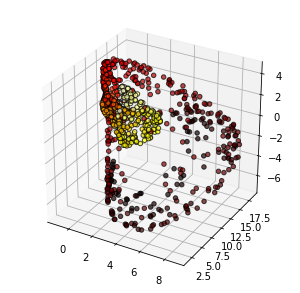

In [148]:
X_rbf_inv = rbf_pca.inverse_transform(X_roll_rbf)


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(X_rbf_inv[:, 0], X_rbf_inv[:, 1], X_rbf_inv[:, 2], 
             c=y, cmap=plt.cm.hot, edgecolor='k', alpha=.7)

#### Selecting a kernel and tuning hyperparameters

In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [154]:
kpca_logreg_pipe = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('clf', LogisticRegression())
])

params = {
    'kpca__gamma': np.linspace(.01, .1, 20),
    'kpca__kernel': ['rbf', 'sigmoid']
}

y = y_roll > 6.9

In [155]:
grid = GridSearchCV(kpca_logreg_pipe, params, cv=3)
grid.fit(X_roll, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('clf', LogisticRegressio...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kpca__kernel': ['rbf', 'sigmoid'], 'kpca__gamma': array([0.01   , 0.01474, 0.01947, 0.02421, 0.02895, 0.03368, 0.03842,
       0.04316, 0.04789, 0.05263, 0.05737, 0.06211, 0.06684, 0.07158,
       0.07632, 0.08105, 0.08579, 0.09053, 0.09526, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [156]:
grid.best_params_

{'kpca__gamma': 0.04315789473684211, 'kpca__kernel': 'rbf'}

In [157]:
best_kpca = grid.best_estimator_.steps[0][1]

In [162]:
rbf_pca = KernelPCA(fit_inverse_transform=True, n_components=2, 
                       kernel=best_kpca.kernel, gamma=best_kpca.gamma)
X_roll_rbf = rbf_pca.fit_transform(X_roll)
X_rbf_inv = rbf_pca.inverse_transform(X_roll_rbf)

In [164]:
# compute pre-image error
mean_squared_error(X_roll, X_rbf_inv)

32.74810176420641

#### Locally Linear Embedding (LLE)

In [183]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS, Isomap, TSNE

In [178]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=9)

X_reduced_lle = lle.fit_transform(X_roll)

Text(0.5,1,'Unrolled Swiss Roll using LLE')

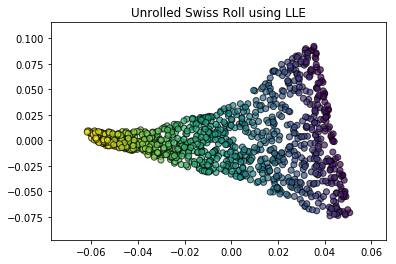

In [182]:
plt.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1], c=y_roll, edgecolors='k', alpha=.7)
plt.title('Unrolled Swiss Roll using LLE')

In [184]:
mds = MDS(n_components=2, random_state=42)
isomap = Isomap(n_components=2)
tsne = TSNE(n_components=2, random_state=42)

In [185]:
X_reduced_mds = mds.fit_transform(X_roll)
X_reduced_iso = isomap.fit_transform(X_roll)
X_reduced_tsne = tsne.fit_transform(X_roll)

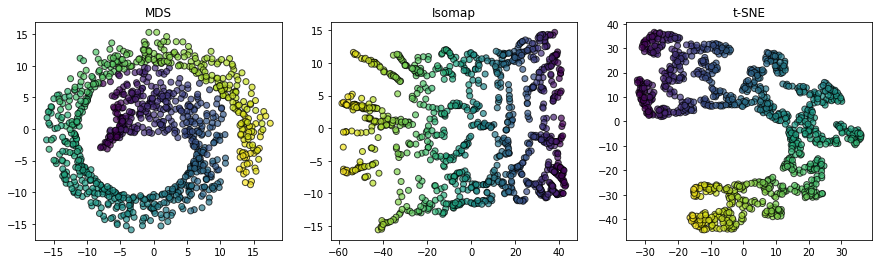

In [186]:
plt.figure(figsize=(15, 4))
for num_plot, data, title in zip((131, 132, 133), 
                                 [X_reduced_mds, X_reduced_iso, X_reduced_tsne], 
                                 ['MDS', 'Isomap', 't-SNE']):
    plt.subplot(num_plot)
    plt.scatter(data[:, 0], data[:, 1], c=y_roll, edgecolors='k', alpha=.7)
    plt.title(title)

In [187]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [188]:
lda = LinearDiscriminantAnalysis(n_components=2)

In [191]:
lda.fit(X_mnist, y_mnist)

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [192]:
X_mnist_lda = lda.transform(X_mnist)

In [193]:
X_mnist_lda.shape

(60000, 2)

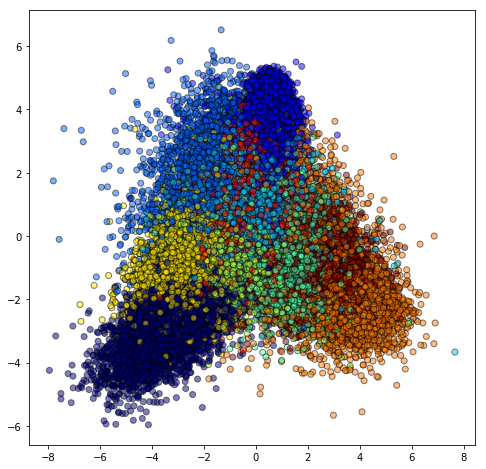

In [196]:
plt.figure(figsize=(8, 8))
plt.scatter(X_mnist_lda[:, 0], X_mnist_lda[:, 1], c=y_mnist, 
            cmap=plt.cm.jet, edgecolors='k', alpha=.5)

### Extra Material – Clustering

#### Introduction – Classification vs Clustering

In [11]:
from sklearn.mixture import GaussianMixture

In [3]:
iris = datasets.load_iris()

In [4]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
X = iris.data
y = iris.target

iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Text(0,0.5,'sepal width (cm)')

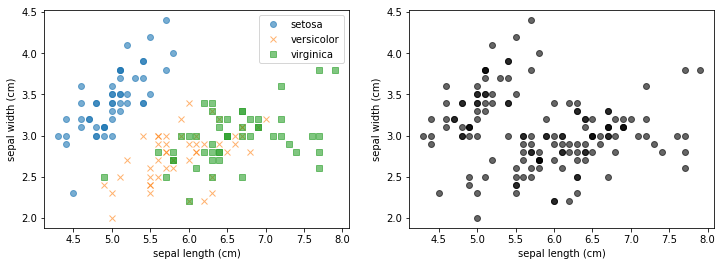

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
for label, (name, marker) in enumerate(zip(iris.target_names, 'oxs')):
    plt.plot(X[y==label, 0], X[y==label, 1], marker, alpha=.6, label=name)
plt.legend()
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])


plt.subplot(122)
plt.plot(X[:, 0], X[:, 1], 'ko', alpha=.6)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])


In [13]:
# Gaussian Mixture
gmx = GaussianMixture(n_components=3, random_state=42)

y_pred = gmx.fit(X).predict(X)

In [24]:
y_pred = np.array([2, 0, 1])[y_pred]

Text(0,0.5,'sepal width (cm)')

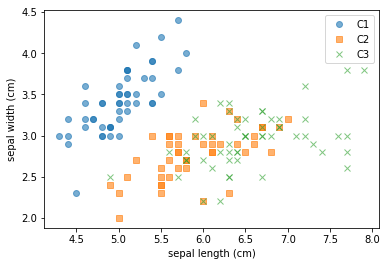

In [25]:
for label, (name, marker) in enumerate(zip(['C1', 'C2', 'C3'], 'osx')):
    plt.plot(X[y_pred==label, 0], X[y_pred==label, 1], marker, alpha=.6, label=name)
plt.legend()
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])

In [26]:
(y == y_pred).mean()

0.9666666666666667

#### K-means

In [34]:
from sklearn.cluster import KMeans

In [27]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [28]:
X, y = datasets.make_blobs(n_samples=2000, 
                           centers=blob_centers, 
                           cluster_std=blob_std, 
                           random_state=7)

In [29]:
X.shape, y.shape

((2000, 2), (2000,))

Text(0,0.5,'$x_2$')

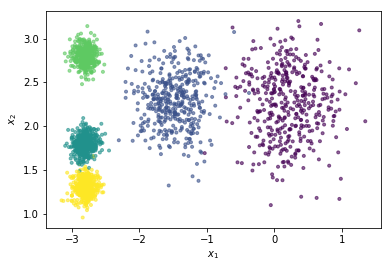

In [33]:
plt.scatter(X[:, 0], X[:, 1], c=y, marker='.', alpha=.6)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

In [36]:
km = KMeans(n_clusters=5, random_state=42)
y_pred = km.fit(X).predict(X)

In [37]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [38]:
y

array([4, 2, 0, ..., 3, 0, 2])

In [39]:
km.labels_

array([4, 0, 1, ..., 2, 1, 0])

In [40]:
np.array([2, 0, 3, 1, 4])[y_pred]

array([4, 2, 0, ..., 3, 0, 2])

In [41]:
km.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [42]:
blob_centers

array([[ 0.2,  2.3],
       [-1.5,  2.3],
       [-2.8,  1.8],
       [-2.8,  2.8],
       [-2.8,  1.3]])

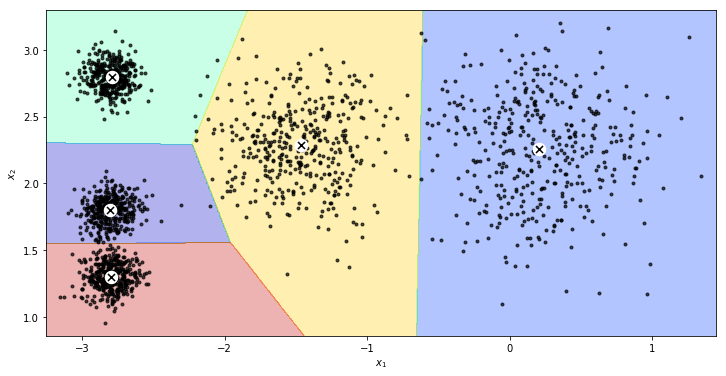

In [54]:
# plot data points
plt.figure(figsize=(12, 6))
plt.plot(X[:, 0], X[:, 1], 'k.', alpha=.7)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

# plot boundary
x1_min, x1_max = X[:, 0].min()-.1, X[:, 0].max()+.1
X2_min, x2_max = X[:, 1].min()-.1, X[:, 1].max()+.1

X1, X2 = np.meshgrid(np.linspace(x1_min, x1_max, 1000), 
                     np.linspace(X2_min, x2_max, 1000))

Y = km.predict(np.c_[X1.ravel(), X2.ravel()]).reshape(X1.shape)

plt.contourf(X1, X2, Y, alpha=.3, cmap=plt.cm.jet)

# plot centroids
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], 
            c='w', marker='o', s=30, zorder=10, linewidths=8)
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], 
            c='k', marker='x', s=50, zorder=10, linewidths=50)

#### hard clustering vs soft clustering

In [55]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])

In [56]:
# soft clustering
km.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In [57]:
# hard clustering
km.predict(X_new)

array([1, 1, 2, 2])

In [63]:
np.linalg.norm(np.tile(X_new, (1, 5)).reshape((-1, 5, 2)) - km.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In [65]:
km.inertia_

211.5985372581684

In [66]:
km.score(X)

-211.59853725816856

#### Mini-Batch K-Means


In [67]:
from sklearn.cluster import MiniBatchKMeans

In [71]:
mb_kmean = MiniBatchKMeans(n_clusters=5, batch_size=100, random_state=42)

In [72]:
mb_kmean.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=3, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [73]:
mb_kmean.inertia_

211.93186531476775

#### Finding the optimal number of clusters


In [75]:
k_clusters = np.arange(2, 11)
k_inertias = np.zeros_like(k_clusters)

for i, k in enumerate(k_clusters):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    k_inertias[i] = km.inertia_

Text(0,0.5,'inertia')

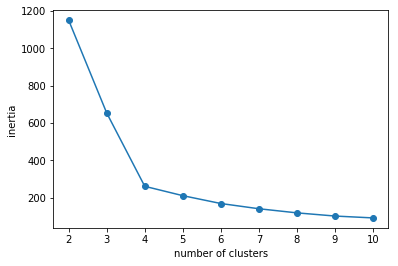

In [77]:
plt.plot(k_clusters, k_inertias, 'o-')
plt.xlabel('number of clusters')
plt.ylabel('inertia')

#### Using Clustering for Preprocessing


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [3]:
X_digits, y_digits = datasets.load_digits(return_X_y=True)

In [4]:
X_digits.shape, y_digits.shape

((1797, 64), (1797,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

X_train.shape, X_test.shape

((1347, 64), (450, 64))

In [10]:
baseline_scores = cross_val_score(LogisticRegression(), X_train, y_train, scoring='accuracy', cv=10)
baseline_scores

array([0.95683453, 0.9352518 , 0.96376812, 0.95620438, 0.93430657,
       0.96296296, 0.96212121, 0.94656489, 0.91538462, 0.96899225])

In [12]:
baseline_scores.mean(), baseline_scores.std()

(0.950239131980938, 0.016197777896299632)

In [18]:
# pipe: kmean transform to 50 cluster distance -> LogisticRegression

km_logreg = Pipeline([
    ('kmean', KMeans(n_clusters=50, random_state=42)),
    ('logreg', LogisticRegression(random_state=42))
])

In [19]:
km_logreg_scores = cross_val_score(km_logreg, X_train, y_train, scoring='accuracy', cv=10)
km_logreg_scores

array([0.98561151, 0.97841727, 0.96376812, 0.98540146, 0.96350365,
       0.98518519, 0.98484848, 0.96946565, 0.93846154, 0.97674419])

In [20]:
km_logreg_scores.mean(), km_logreg_scores.std()

(0.973140704580618, 0.014232655351092766)

In [23]:
# find best k
grid_params = {
    'kmean__n_clusters': range(2, 100, 5),
}

km_logreg_grid = GridSearchCV(km_logreg, grid_params, cv=10, 
                              scoring='accuracy', verbose=2, n_jobs=2)

In [24]:
km_logreg_grid.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  2.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kmean', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=...lty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'kmean__n_clusters': range(2, 100, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [27]:
km_logreg_grid.best_params_, km_logreg_grid.best_score_

({'kmean__n_clusters': 82}, 0.9769858945805494)

In [28]:
km_logreg_grid.best_estimator_.score(X_test, y_test)

0.9866666666666667

In [30]:
km_logreg.fit(X_train, y_train).score(X_test, y_test)

0.9822222222222222

#### clustering for semi-supervised learning

In [31]:
n_labels = 50

In [33]:
# baseline from random 50 samples
log_reg = LogisticRegression().fit(X_train[:n_labels], y_train[:n_labels])
log_reg.score(X_test, y_test)

0.8266666666666667

In [36]:
k = 50
k50 = KMeans(n_clusters=k, random_state=42)

X_train_dist = k50.fit_transform(X_train)

In [37]:
X_train_dist.shape

(1347, 50)

In [48]:
# 50 centroid representative from training samples
centroid_represent_idx = np.argmin(X_train_dist, axis=0)

X_train_centroid = X_train[centroid_represent_idx]
y_train_centroid = y_train[centroid_represent_idx]

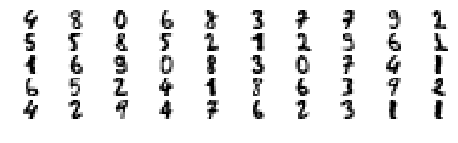

In [47]:
plt.figure(figsize=(8, 2))
for i, im_row in enumerate(X_train_centroid, start=1):
    plt.subplot(k//10, 10, i)
    plt.imshow(im_row.reshape((8, 8)), cmap=plt.cm.binary)
    plt.axis('off')

In [49]:
# train LogisticRegression on 50 centroid representatives
log_reg.fit(X_train_centroid, y_train_centroid)
log_reg.score(X_test, y_test)

0.9244444444444444

In [71]:
# train using y_cluster by kmean
y_propagate = y_train_centroid[k50.labels_]

log_reg = LogisticRegression()
log_reg.fit(X_train, y_propagate)
log_reg.score(X_test, y_test)

0.9288888888888889

In [68]:
# train using only 20 percentile samples that close to its centroid
percentile = 20

X_cluster_dist = X_train_dist[range(len(X_train)), k50.labels_]

for c in range(k):
    cluster_c = k50.labels_==c
    cluster_dist = X_cluster_dist[cluster_c]
    p20 = np.percentile(cluster_dist, percentile)
    cluster_above = X_cluster_dist > p20
    X_cluster_dist[cluster_c & cluster_above] = -1

In [72]:
X_p20_centroid_rep = X_train[X_cluster_dist != -1]
y_p20_centroid_rep = y_propagate[X_cluster_dist != -1]

X_p20_centroid_rep.shape, y_p20_centroid_rep.shape

((291, 64), (291,))

In [73]:
log_reg.fit(X_p20_centroid_rep, y_p20_centroid_rep)
log_reg.score(X_test, y_test)

0.9422222222222222

In [74]:
(y_train[X_cluster_dist!=-1] == y_p20_centroid_rep).mean()

0.9896907216494846

#### DBSCAN < Density-Based Spatial Clustering of Applications with Noise>

In [75]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier

In [76]:
X, y = datasets.make_moons(n_samples=1000, noise=0.05, random_state=42)

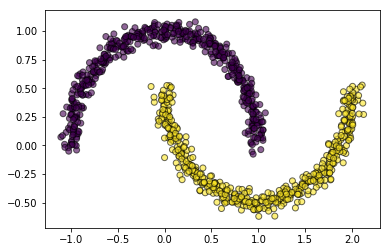

In [83]:
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=.6, edgecolors='k', linewidths=1)

In [103]:
dbscan = DBSCAN(eps=.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [86]:
dbscan.components_.shape

(808, 2)

In [88]:
dbscan.labels_.shape

(1000,)

In [90]:
dbscan.core_sample_indices_.shape

(808,)

In [104]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [99]:
def plot_dbscan(dbscan, X):
    core_idx = dbscan.core_sample_indices_
    non_core = dbscan.labels_ == -1

    plt.scatter(X[core_idx, 0], X[core_idx, 1], c=dbscan.labels_[core_idx], 
                alpha=.6, edgecolors='k', linewidths=1)

    plt.plot(X[non_core, 0], X[non_core, 1], 'k.')

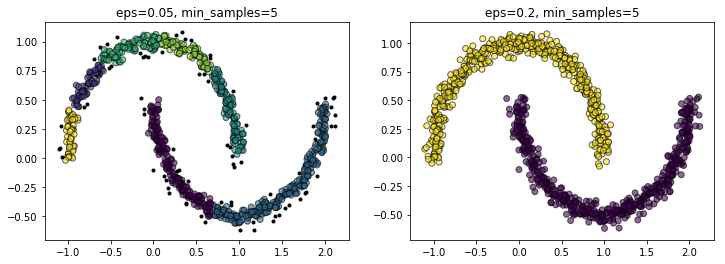

In [105]:
plt.figure(figsize=(12, 4))
for i, (eps, min_samples) in enumerate(zip([.05, .2], [5, 5]), start=1):
    plt.subplot(1, 2, i)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    plot_dbscan(dbscan, X)
    plt.title("eps={}, min_samples={}".format(eps, min_samples))

In [107]:
knn = KNeighborsClassifier()
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Text(0,0.5,'$x_2$')

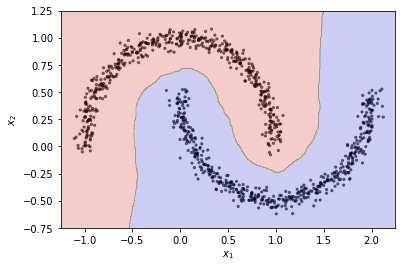

In [111]:
X1, X2 = np.meshgrid(np.linspace(-1.25, 2.25, 500),
                     np.linspace(-.75, 1.25, 500))

Y = knn.predict(np.c_[X1.ravel(), X2.ravel()]).reshape(X1.shape)

plt.contourf(X1, X2, Y, cmap=plt.cm.jet, alpha=.2)
plt.scatter(dbscan.components_[:, 0], dbscan.components_[:, 1], s=5, alpha=.5, edgecolors='k', 
            c=knn.predict(dbscan.components_), cmap=plt.cm.jet)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

#### Spectral Clustering


In [112]:
from sklearn.cluster import SpectralClustering

In [123]:
sc1 = SpectralClustering(n_clusters=2, gamma=20, random_state=42)

In [124]:
sc1.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=20, kernel_params=None,
          n_clusters=2, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=42)

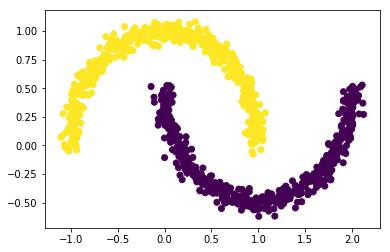

In [125]:
plt.scatter(X[:, 0], X[:, 1], c=sc1.labels_)

#### Gaussian Mixtures

In [3]:
from sklearn.mixture import GaussianMixture

In [4]:
X1, y1 = datasets.make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))

X2, y2 = datasets.make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

X.shape, y.shape

((1250, 2), (1250,))

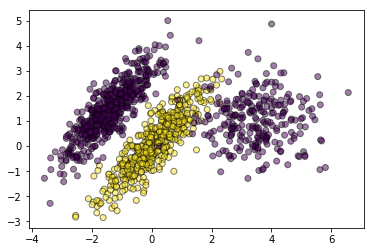

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=.5, edgecolors='k')

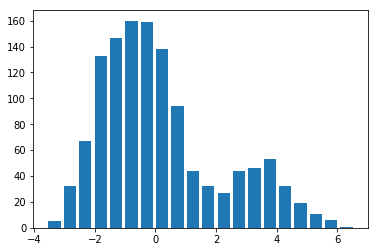

In [12]:
plt.hist(X[:, 0], bins=20, rwidth=.8)
plt.show()

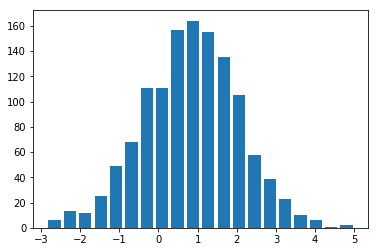

In [13]:
plt.hist(X[:, 1], bins=20, rwidth=.8)
plt.show()

In [14]:
# probability distribution of each cluster
np.array([500, 500, 250]) / 1250

array([0.4, 0.4, 0.2])

In [15]:
gmm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=10, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [16]:
gmm.weights_

array([0.20965228, 0.4000662 , 0.39028152])

In [17]:
gmm.means_

array([[ 3.39909717,  1.05933727],
       [-1.40763984,  1.42710194],
       [ 0.05135313,  0.07524095]])

In [18]:
gmm.covariances_

array([[[ 1.14807234, -0.03270354],
        [-0.03270354,  0.95496237]],

       [[ 0.63478101,  0.72969804],
        [ 0.72969804,  1.1609872 ]],

       [[ 0.68809572,  0.79608475],
        [ 0.79608475,  1.21234145]]])

In [19]:
gmm.converged_

True

In [20]:
gmm.n_iter_

3

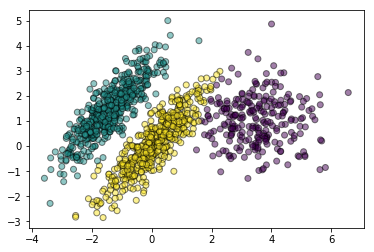

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=gmm.predict(X), alpha=.5, edgecolors='k')

In [22]:
# hard clustering
gmm.predict(X)

array([2, 2, 1, ..., 0, 0, 0], dtype=int64)

In [23]:
# soft clustering
gmm.predict_proba(X)

array([[2.32389467e-02, 6.77397850e-07, 9.76760376e-01],
       [1.64685609e-02, 6.75361303e-04, 9.82856078e-01],
       [2.01535333e-06, 9.99923053e-01, 7.49319577e-05],
       ...,
       [9.99999571e-01, 2.13946075e-26, 4.28788333e-07],
       [1.00000000e+00, 1.46454409e-41, 5.12459171e-16],
       [1.00000000e+00, 8.02006365e-41, 2.27626238e-15]])

In [24]:
X_new, y_new = gmm.sample(6)

In [25]:
X_new

array([[ 2.95400315,  2.63680992],
       [-1.16654575,  1.62792705],
       [-1.39477712, -1.48511338],
       [ 0.27221525,  0.690366  ],
       [ 0.54095936,  0.48591934],
       [ 0.38064009, -0.56240465]])

In [26]:
y_new

array([0, 1, 2, 2, 2, 2])

In [27]:
# estimate weighted log of pdf at a point using the score_samples() method
gmm.score_samples(X_new)

array([-4.80269976, -2.01524058, -3.51660935, -2.22880963, -2.18454233,
       -3.82874339])

In [30]:
# check if pdf integrates to 1 in whole space
resolution = 100
xs = np.arange(-10, 10, 1/resolution)
X1, X2 = np.meshgrid(xs, xs)
X_full = np.c_[X1.ravel(), X2.ravel()]

log_pdf = gmm.score_samples(X_full)
pdf = np.exp(log_pdf)
total_prob = pdf.sum() / resolution**2
total_prob

0.9999999999217849

In [31]:
xs.shape

(2000,)

In [ ]:
plt.contour()

In [32]:
np.logspace(0, 2, 12)

array([  1.        ,   1.51991108,   2.3101297 ,   3.51119173,
         5.33669923,   8.11130831,  12.32846739,  18.73817423,
        28.48035868,  43.28761281,  65.79332247, 100.        ])

In [34]:
gmm.score_samples(X).max()

-1.9605448367158371

In [106]:
from matplotlib.colors import LogNorm

def plot_gaussian(clusterer, X, resolution=1000):
    xmin, xmax = X.min(axis=0) - .1, X.max(axis=0) + .1
    xx, yy = np.meshgrid(np.linspace(xmin[0], xmax[0], resolution),
                         np.linspace(xmin[1], xmax[1], resolution))

    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, 
                 norm=LogNorm(vmin=2, vmax=30), 
                 levels=np.logspace(0, 2, 12))

    plt.contour(xx, yy, Z, norm=LogNorm(vmin=2, vmax=30), linewidths=1, 
                levels=np.logspace(0, 2, 12), colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='r', linestyles='--')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    
    # plot centroids
    weights = clusterer.weights_
    centroids = clusterer.means_[weights > weights.max()/10]
    
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', 
                linewidths=8, color='w', s=50, zorder=10)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', 
                linewidths=50, s=30, color='k', zorder=11)

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

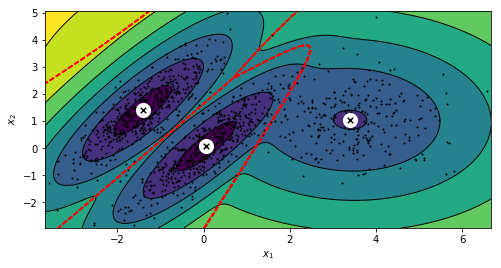

In [107]:
plt.figure(figsize=(8, 4))
plot_gaussian(gmm, X)



You can impose constraints on the covariance matrices that the algorithm looks for by setting the covariance_type hyperparameter:

* "full" (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* "tied": all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* "spherical": all clusters must be spherical, but they can have different diameters (i.e., different variances).
* "diag": clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).



In [66]:
gmm_full = GaussianMixture(n_components=3, covariance_type='full', n_init=10, random_state=42).fit(X)
gmm_tied = GaussianMixture(n_components=3, covariance_type='tied', n_init=10, random_state=42).fit(X)
gmm_sphere = GaussianMixture(n_components=3, covariance_type='spherical', n_init=10, random_state=42).fit(X)
gmm_diag = GaussianMixture(n_components=3, covariance_type='diag', n_init=10, random_state=42).fit(X)

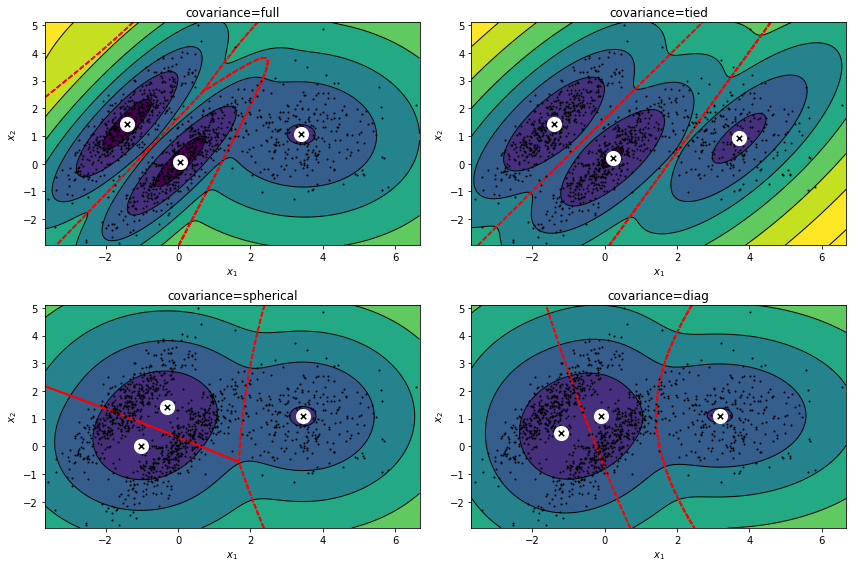

In [70]:
fig = plt.figure(figsize=(12, 8))

for i, cls in enumerate([gmm_full, gmm_tied, gmm_sphere, gmm_diag], start=1):
    plt.subplot(2, 2, i)
    plot_gaussian(cls, X)
    plt.title("covariance=`{}`".format(cls.covariance_type))
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
fig.tight_layout()

#### Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [71]:
densities = gmm.score_samples(X)

In [76]:
density_threshold = np.percentile(densities, q=4)
anomaly = X[densities < density_threshold]

In [77]:
anomaly.shape

(50, 2)

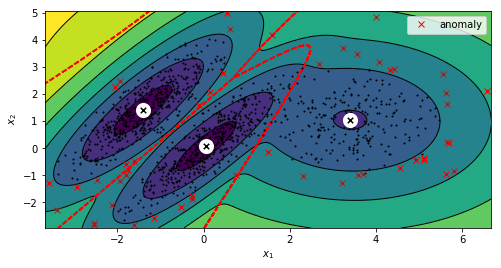

In [82]:
fig = plt.figure(figsize=(8, 4))

plot_gaussian(gmm, X)
plt.plot(anomaly[:, 0], anomaly[:, 1], 'rx', label='anomaly')
plt.legend()

#### Model selection



We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

   * $m$ is the number of instances.
   * $p$ is the number of parameters learned by the model.
   * $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).


In [89]:
gmm_full.bic(X), gmm_diag.bic(X), gmm_tied.bic(X), gmm_sphere.bic(X)

(8189.74345832983, 8994.244588222722, 8588.714627750927, 8977.203915688453)

In [86]:
gmm.aic(X)

8102.518178214792

In [93]:
n_cluster = 3
n_dim = 2

weight_params = n_cluster - 1
mean_params = n_cluster * n_dim
covariance_params = n_cluster * n_dim * (n_dim+1) // 2
total_params = weight_params + mean_params + covariance_params

bic = total_params * np.log(len(X)) - 2*gmm.score(X)*len(X)
bic

8189.74345832983

In [94]:
# average log-likelihood of the given data X
gmm.score(X) * len(X)

-4034.259089107396

In [95]:
gmm_k1_to_k10 = [GaussianMixture(n_components=k, random_state=42, n_init=10).fit(X) 
                 for k in range(1, 11)]

In [96]:
bic_k1_to_k10 = [model.bic(X) for model in gmm_k1_to_k10]
aic_k1_to_k10 = [model.aic(X) for model in gmm_k1_to_k10]

Text(0.5,1,'AIC & BIC by k components')

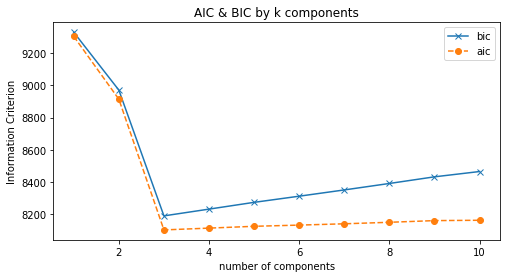

In [99]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), bic_k1_to_k10, '-x', label='bic')
plt.plot(range(1, 11), aic_k1_to_k10, '--o', label='aic')
plt.xlabel('number of components')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('AIC & BIC by k components')

#### Variational Bayesian Gaussian Mixtures


In [100]:
from sklearn.mixture import BayesianGaussianMixture

In [101]:
bgm = BayesianGaussianMixture(n_components=10, random_state=42, n_init=10)
bgm.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=100, mean_precision_prior=None, mean_prior=None,
            n_components=10, n_init=10, random_state=42, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [103]:
bgm.weights_.round(2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

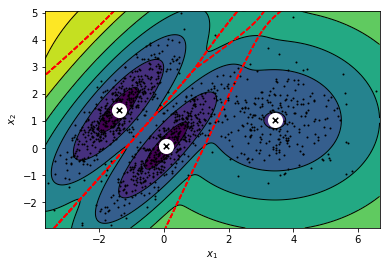

In [108]:
plot_gaussian(bgm, X)

In [105]:
bgm.means_

array([[ 0.06945986,  0.09573446],
       [ 3.42981808,  1.0391434 ],
       [-1.4021931 ,  1.42732498],
       [ 0.16952168,  0.82239288],
       [ 0.16952151,  0.82239288],
       [ 0.16952151,  0.82239288],
       [ 0.16952151,  0.82239288],
       [ 0.16952151,  0.82239288],
       [ 0.16952151,  0.82239288],
       [ 0.16952151,  0.82239288]])

In [109]:
X_moons, y_moons = datasets.make_moons(1000, noise=.05, random_state=42)

In [110]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=100, mean_precision_prior=None, mean_prior=None,
            n_components=10, n_init=10, random_state=42, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

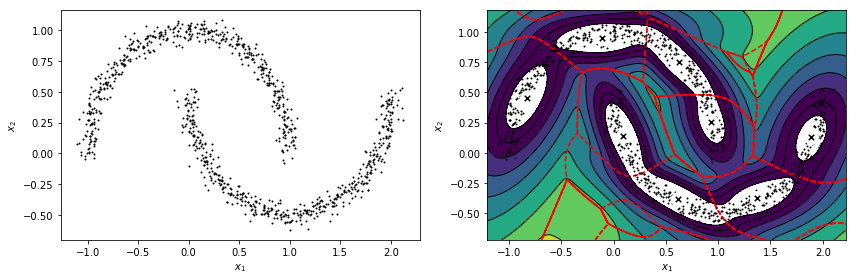

In [114]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(X_moons[:, 0], X_moons[:, 1], 'k.', markersize=2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.subplot(1, 2, 2)
plot_gaussian(bgm, X_moons)

fig.tight_layout()

In [115]:
# 8 clusters found, in fact there are only 2 clusters
bgm.weights_.round(2)

array([0.12, 0.12, 0.13, 0.16, 0.12, 0.13, 0.14, 0.  , 0.08, 0.  ])

#### Exercises

##### ex.9

In [3]:
from keras.datasets.mnist import load_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


import time

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
(X_train, y_train), (X_test, y_test) = load_data()

X_train = X_train.reshape((len(X_train), -1)).astype('float32') / 255.
X_test = X_test.reshape((len(X_test), -1)).astype('float32') / 255.

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [5]:
t0 = time.time()
rf_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

print("training time: {} s".format(time.time() - t0))

training time: 8.826305866241455 s


In [6]:
print(accuracy_score(y_test, rf_clf.predict(X_test)))

0.9492


In [7]:
pca = PCA(n_components=.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [8]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca.shape, X_test_pca.shape

((60000, 154), (10000, 154))

In [9]:
t0 = time.time()
pca_rf_clf = RandomForestClassifier(random_state=42).fit(X_train_pca, y_train)

print('training time: {} s'.format(time.time() - t0))

training time: 23.26943325996399 s


Oh no! Training is actually more than twice slower now! How can that be? 

Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. See figure 8-6 (the manifold_decision_boundary_plot* plots above). If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

In [10]:
print(accuracy_score(y_test, pca_rf_clf.predict(X_test_pca)))

0.8947


It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. :(

In [11]:
# using LogisticRegression with softmax
t0 = time.time()
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train, y_train)

print('training time: {} s'.format(time.time() - t0))

training time: 18.762776613235474 s


In [12]:
accuracy_score(y_test, lr.predict(X_test))

0.9263

In [13]:
# using LogisticRegression + PCA
t0 = time.time()
lr_pca = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42).fit(X_train_pca, y_train)

print('training time: {} s'.format(time.time() - t0))

training time: 8.86734127998352 s


In [15]:
accuracy_score(y_test, lr_pca.predict(X_test_pca))

0.9228

#### ex.10

In [16]:
from sklearn.manifold import TSNE

In [19]:
n_sample = 10000

idx = np.random.permutation(len(X_train))[:n_sample]

X_mnist, y_mnist = X_train[idx], y_train[idx]

tsne = TSNE(n_components=2, random_state=42)

In [20]:
pd.value_counts(y_mnist, normalize=True)

7    0.1113
1    0.1095
3    0.1066
0    0.1012
2    0.0997
9    0.0997
8    0.0976
6    0.0933
5    0.0908
4    0.0903
dtype: float64

In [22]:
X_tsne = tsne.fit_transform(X_mnist)

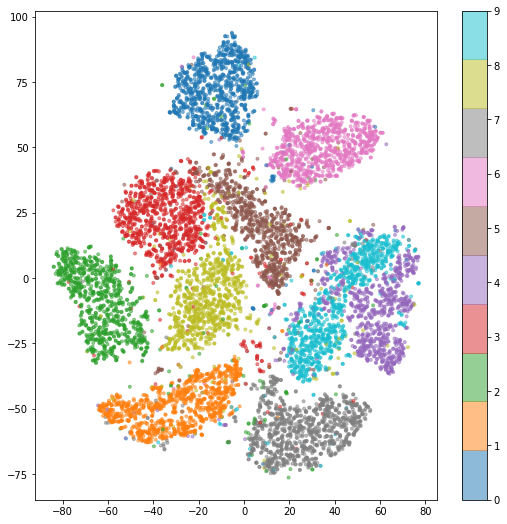

In [25]:
plt.figure(figsize=(9, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mnist, marker='.', alpha=.5, cmap=plt.cm.tab10)
plt.colorbar()

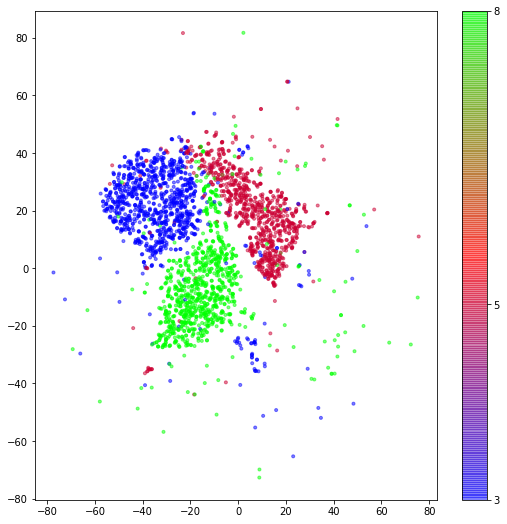

In [31]:
idx_358 = (y_mnist==3) | (y_mnist==5) | (y_mnist==8)

plt.figure(figsize=(9, 9))
plt.scatter(X_tsne[idx_358, 0], X_tsne[idx_358, 1], c=y_mnist[idx_358], marker='.', alpha=.5, cmap=plt.cm.brg)
cbar = plt.colorbar()
cbar.set_ticks([3, 5, 8])
cbar.set_ticklabels(['3', '5', '8'])

In [34]:
tsne_358 = TSNE(n_components=2, random_state=425)

X_tsne_358 = tsne_358.fit_transform(X_mnist[idx_358])

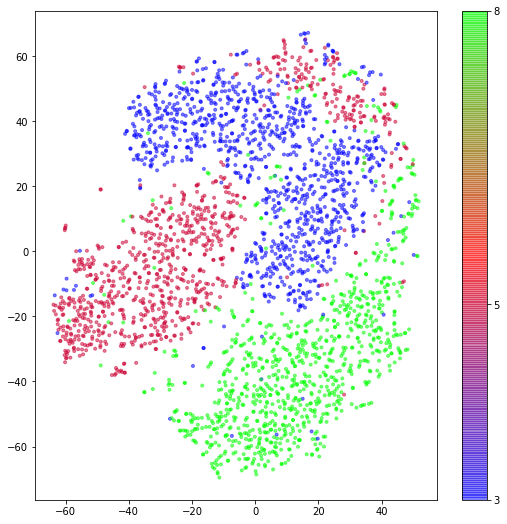

In [35]:
plt.figure(figsize=(9, 9))
plt.scatter(X_tsne_358[:, 0], X_tsne_358[:, 1], c=y_mnist[idx_358], marker='.', alpha=.5, cmap=plt.cm.brg)
cbar = plt.colorbar()
cbar.set_ticks([3, 5, 8])
cbar.set_ticklabels(['3', '5', '8'])

In [40]:
cmap = plt.cm.get_cmap('jet')
digits = np.unique(y_mnist)

In [44]:
a = np.array([[0, 0]])

In [45]:
a.shape

(1, 2)

In [46]:
np.array(a).shape

(1, 2)

In [48]:
np.r_[a, [[0, 0]]].shape

(2, 2)

In [64]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage


def plot_digits(X, y, min_distance=0.05, images=None, fig_size=(13, 10)):
    X_norm = MinMaxScaler().fit_transform(X)

    cmap = plt.get_cmap('jet')
    digits = np.unique(y)

    plt.figure(figsize=fig_size)
    for digit in digits:
        plt.scatter(X_norm[y==digit, 0], X_norm[y==digit, 1], c=cmap(digit/9), alpha=.5)

    plt.axis('off')
    ax = plt.gca()

    neighbors = [[10., 10.]]
    for i, xy in enumerate(X_norm):
        dist = np.linalg.norm(neighbors - xy, axis=1).min()
        if dist > min_distance:
            neighbors = np.r_[neighbors, [xy]]
            if images is None:
                plt.text(xy[0], xy[1], s=str(int(y[i])), color='k', fontdict={'fontsize':16})
            else:
                img = images[i].reshape((28, 28))
                img_box = AnnotationBbox(OffsetImage(img, cmap=plt.cm.binary), xy)
                ax.add_artist(img_box)

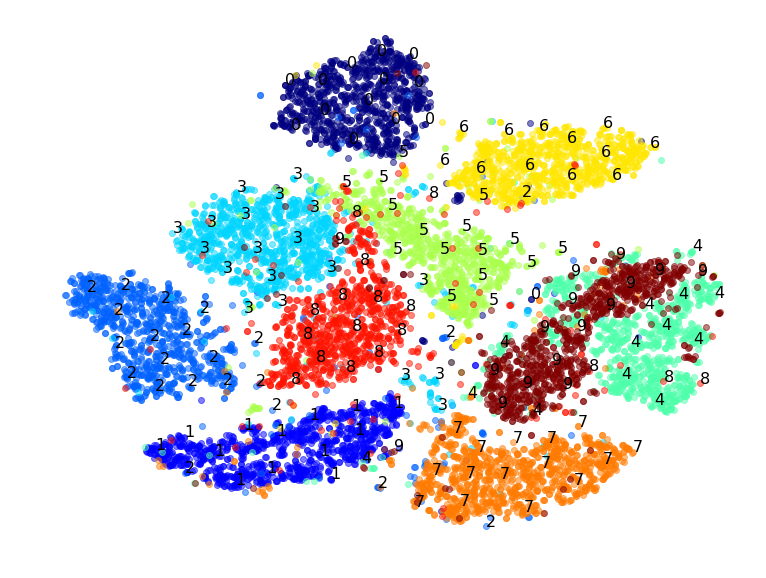

In [65]:
plot_digits(X_tsne, y_mnist)

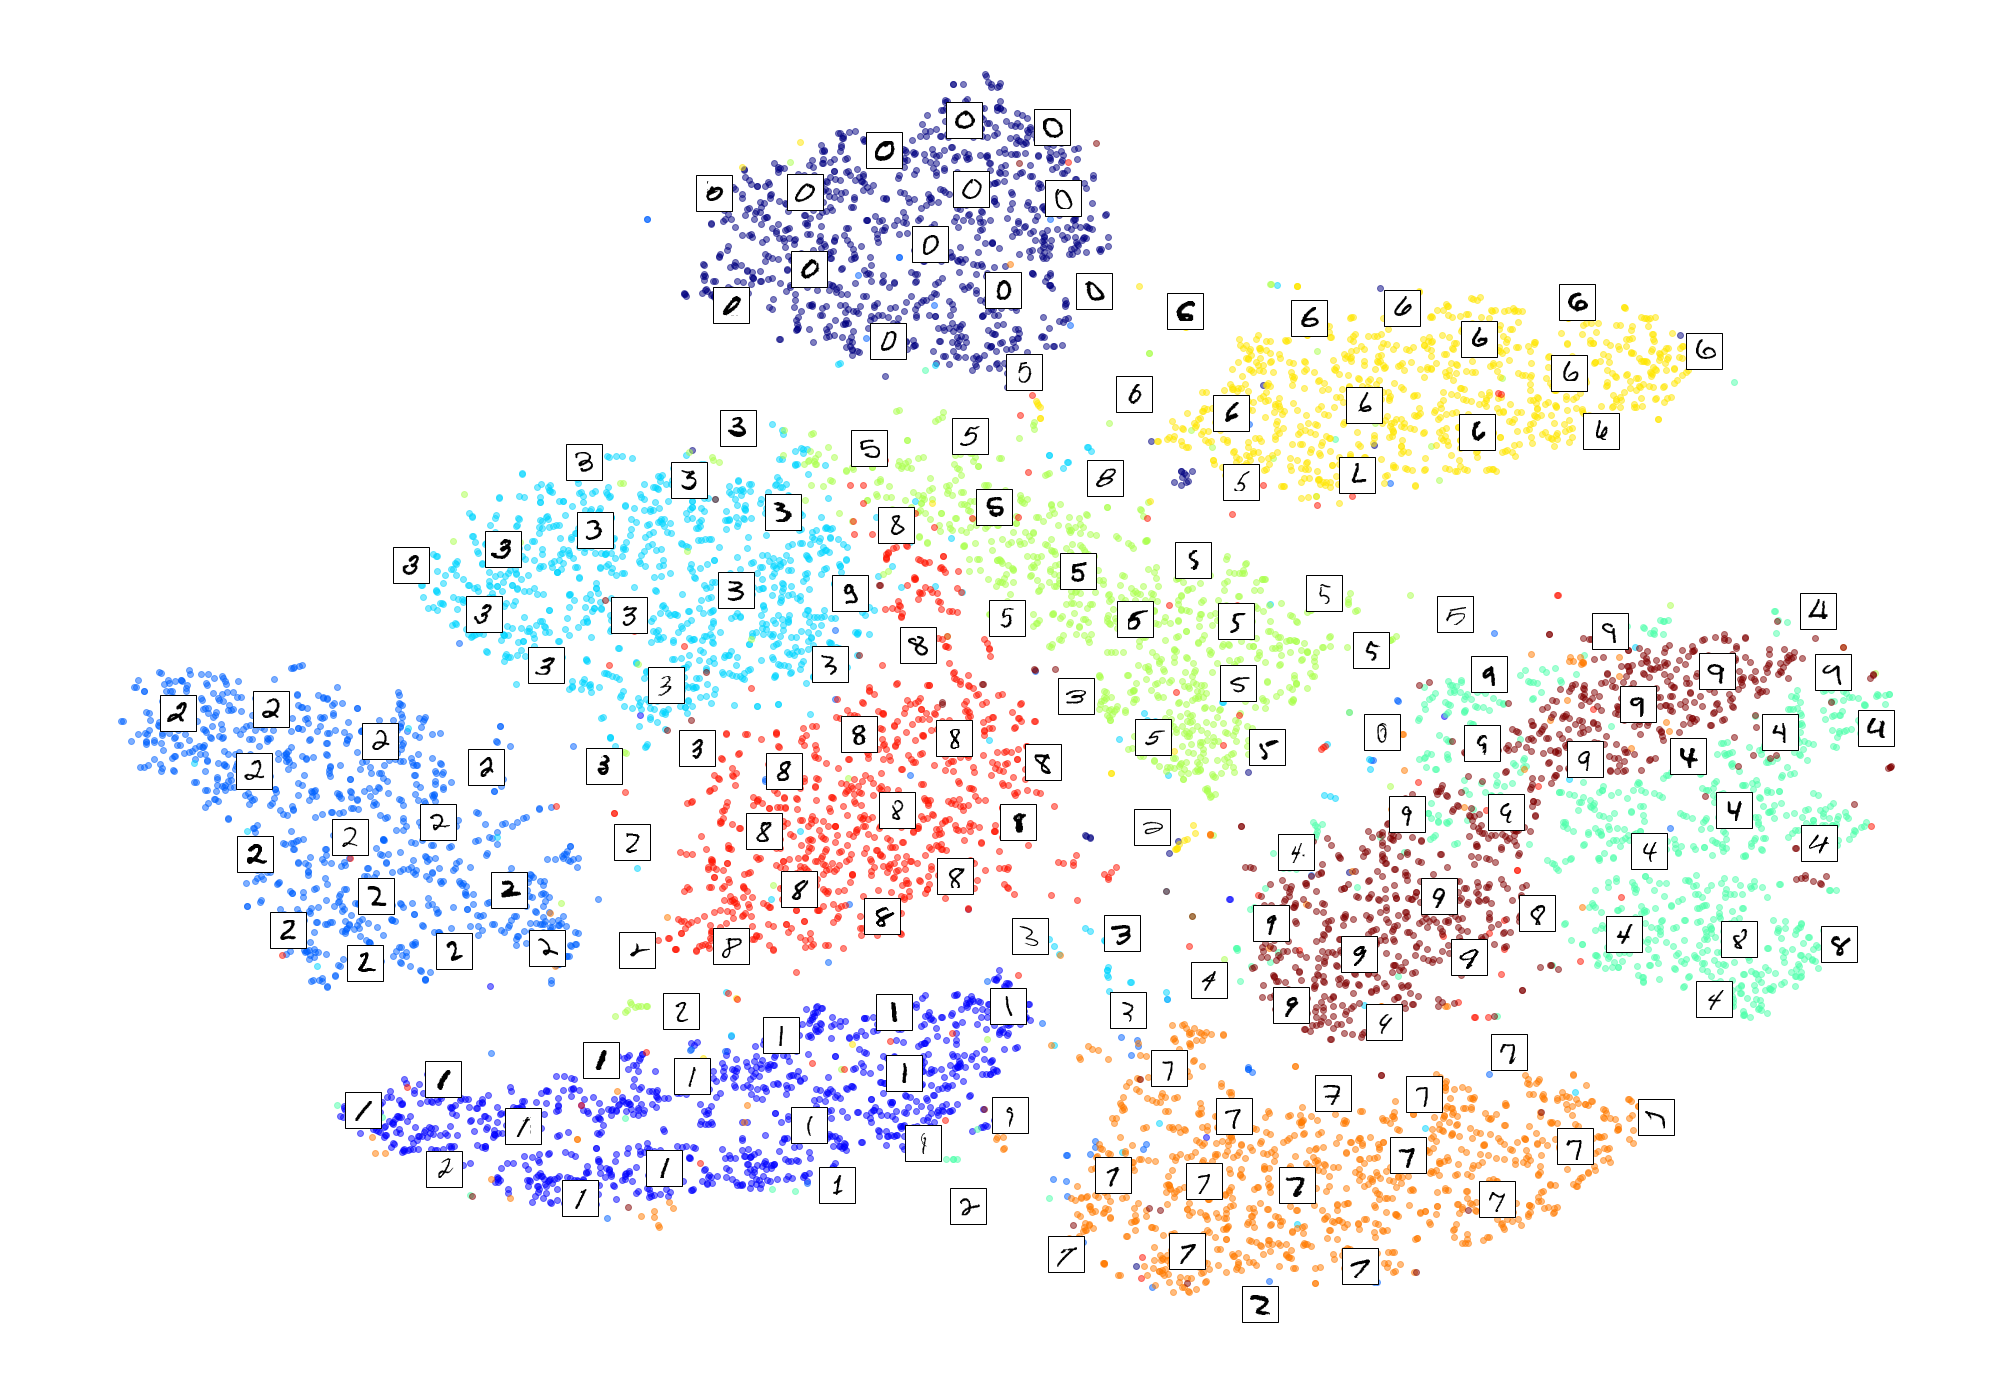

In [66]:
plot_digits(X_tsne, y_mnist, images=X_mnist, fig_size=(35, 25))

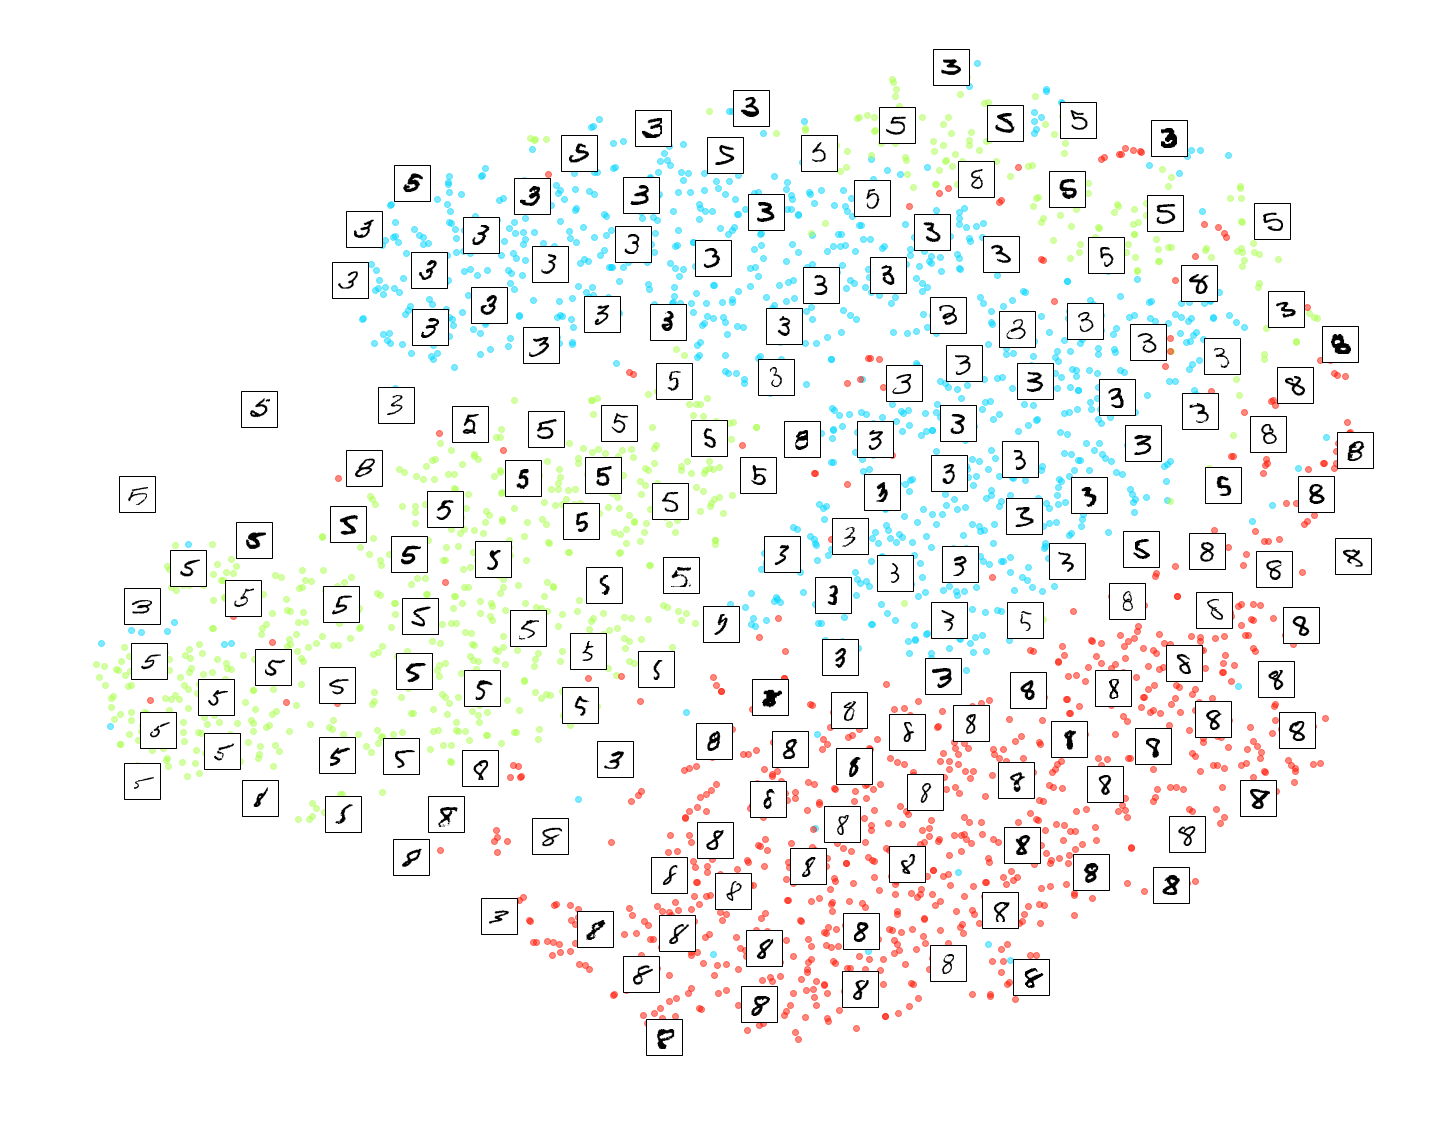

In [67]:
plot_digits(X_tsne_358, y_mnist[idx_358], images=X_mnist[idx_358], fig_size=(25, 20))

In [68]:
# try PCA
from sklearn.decomposition import PCA

In [69]:
t0 = time.time()
pca = PCA(n_components=2, random_state=2)
X_pca = pca.fit_transform(X_mnist)
print('training time: {} s'.format(time.time() - t0))

training time: 0.24717330932617188 s


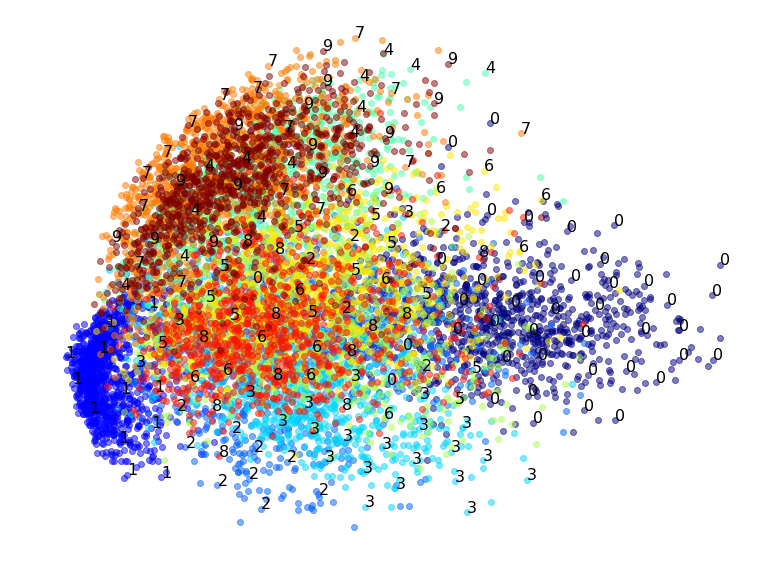

In [71]:
plot_digits(X_pca, y_mnist, images=None)

In [90]:
# try LLE
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_neighbors=30, n_components=2, random_state=42)

In [91]:
t0 = time.time()
X_lle = lle.fit_transform(X_mnist)
print('training time: {} s'.format(time.time() - t0))

training time: 437.1698331832886 s


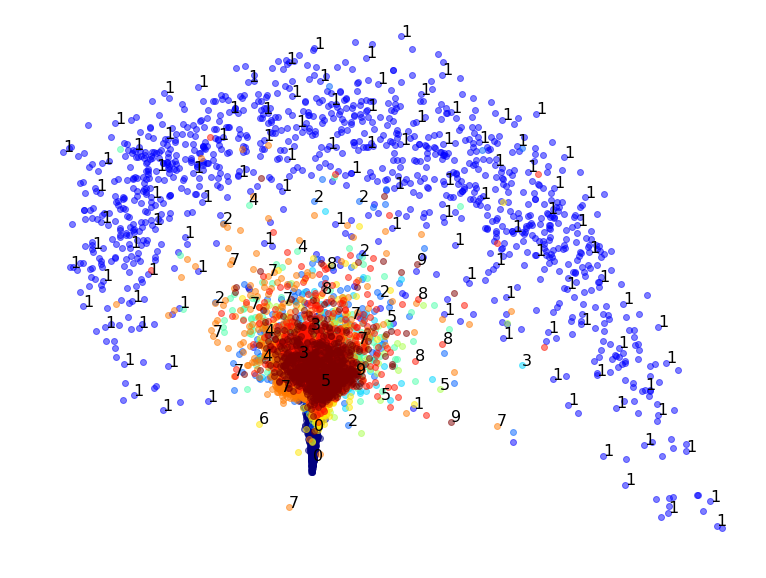

In [92]:
plot_digits(X_lle, y_mnist)

training time: 85.11743330955505 s


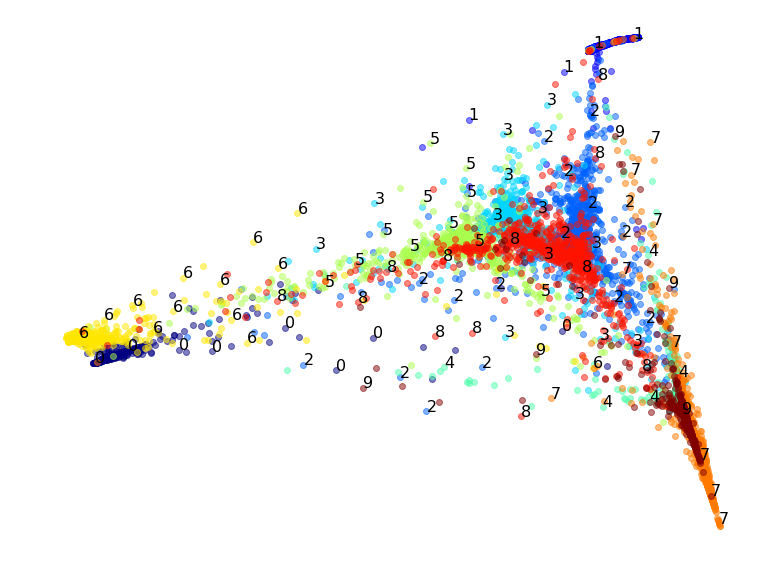

In [76]:
# pca + lle

t0 = time.time()
pca_lle = Pipeline([
    ('pca', PCA(n_components=.95, random_state=42)),
    ('lle', LocallyLinearEmbedding(n_components=2, random_state=2))
])

X_pca_lle = pca_lle.fit_transform(X_mnist)
print('training time: {} s'.format(time.time() - t0))

plot_digits(X_pca_lle, y_mnist)

In [78]:
# kernel pca tuning
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from scipy.stats import reciprocal


In [81]:
pca_lr_pipe = Pipeline([
    ('kpca', KernelPCA(n_components=10, kernel='rbf')),
    ('lr', LogisticRegression())
])

reci_gamma = reciprocal(1e-2, 1)
params = {
    'kpca__gamma': reci_gamma,
    'kpca__n_components': range(10, 151, 10),
}

pca_lr_grid = RandomizedSearchCV(pca_lr_pipe, params, verbose=2, scoring='accuracy', n_iter=10)

In [82]:
pca_lr_grid.fit(X_mnist, y_mnist)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] kpca__gamma=0.32424430610314203 .................................
[CV] .................. kpca__gamma=0.32424430610314203, total=  19.5s
[CV] kpca__gamma=0.32424430610314203 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.3s remaining:    0.0s


[CV] .................. kpca__gamma=0.32424430610314203, total=  19.5s
[CV] kpca__gamma=0.32424430610314203 .................................
[CV] .................. kpca__gamma=0.32424430610314203, total=  19.8s
[CV] kpca__gamma=0.43662487524233634 .................................
[CV] .................. kpca__gamma=0.43662487524233634, total=  19.3s
[CV] kpca__gamma=0.43662487524233634 .................................
[CV] .................. kpca__gamma=0.43662487524233634, total=  19.3s
[CV] kpca__gamma=0.43662487524233634 .................................
[CV] .................. kpca__gamma=0.43662487524233634, total=  19.4s
[CV] kpca__gamma=0.06661617221277169 .................................
[CV] .................. kpca__gamma=0.06661617221277169, total=  19.5s
[CV] kpca__gamma=0.06661617221277169 .................................
[CV] .................. kpca__gamma=0.06661617221277169, total=  19.4s
[CV] kpca__gamma=0.06661617221277169 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 11.0min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=10, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('lr', LogisticRegression(C...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'kpca__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B50B036550>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [84]:
pca_lr_grid.best_params_, pca_lr_grid.best_score_

({'kpca__gamma': 0.012609798523801879}, 0.7586)

training time: 86.39985942840576 s


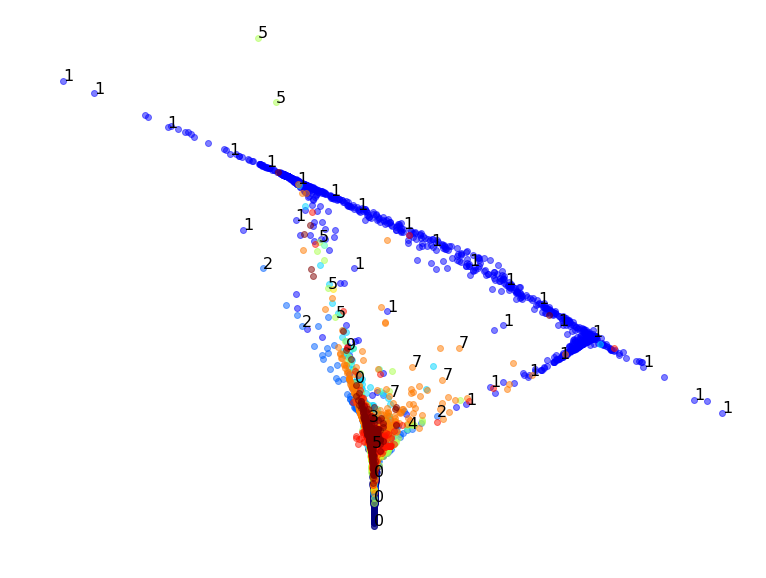

In [86]:
# kernel pca + lle
kpca_lle = Pipeline([
    ('kpca', KernelPCA(n_components=10, kernel='rbf', gamma=0.0126, random_state=42)),
    ('lle', LocallyLinearEmbedding(n_components=2, random_state=42))
])

t0 = time.time()
X_pca_lle = kpca_lle.fit_transform(X_mnist)
print('training time: {} s'.format(time.time() - t0))

plot_digits(X_pca_lle, y_mnist)

In [87]:
# try MDS
from sklearn.manifold import MDS

m = 2000

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


training time: 27.270095825195312 s


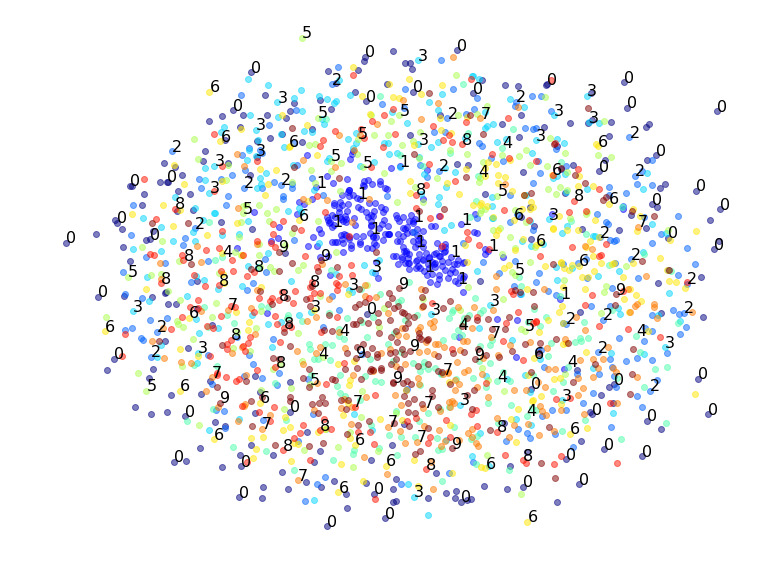

In [93]:
mds = MDS(n_components=2, random_state=42, n_init=1, max_iter=100)

t0 = time.time()
X_mds = mds.fit_transform(X_mnist[:m])
print('training time: {} s'.format(time.time() - t0))

plot_digits(X_mds, y_mnist[:m])

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


training time: 27.057096481323242 s


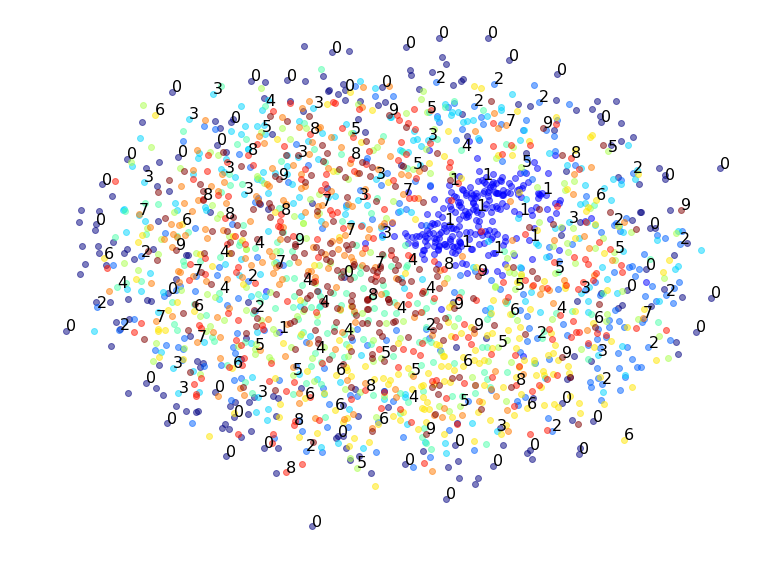

In [94]:
# try pca + mds

pca_mds = Pipeline([
    ('pca', PCA(n_components=95)),
    ('mds', MDS(n_components=2, n_init=1, max_iter=100))
])

t0 = time.time()
X_mds = pca_mds.fit_transform(X_mnist[:m])
print('training time: {} s'.format(time.time() - t0))

plot_digits(X_mds, y_mnist[:m])

In [ ]:
#